# Power spectra computation in `HEALPIX` pixellisation

## Introduction



This tutorial shows how to compute the power spectra of spin 0 and 2 fields. We will use the `HEALPIX`
pixellisation to pass through the different steps of generation. If you are interested on doing the
same thing with `CAR` pixellisation, you can have a look at this [file](tutorial_spectra_car_spin0and2.ipynb).

The `HEALPIX` survey mask will be a disk of radius 25 degree centered on longitude 30 degree and latitude 50 degree, It will have a resolution nside=1024.

We simulate 2 splits with 5 µK.arcmin noise and we also include a point source mask with 100 holes of size 10
arcminutes. We appodize the survey mask with an apodisation of 1 degree and the point source mask
with an apodisation of 0.3 degree. We finally compute the spectra between the 2 splits of data up to
`lmax=1000`.

## Preamble



Versions used for this tutorial



In [1]:
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pixell
import pspy

print("     Numpy :", np.__version__)
print("    Healpy :", hp.__version__)
print("Matplotlib :", mpl.__version__)
print("    pixell :", pixell.__version__)
print("      pspy :", pspy.__version__)

     Numpy : 1.26.3
    Healpy : 1.16.6
Matplotlib : 3.8.2
    pixell : 0.21.1
      pspy : 1.7.0+1.gafa4ce9.dirty


Set Planck colormap as default



In [2]:
pixell.colorize.mpl_setdefault("planck")

## Generation of the templates, mask and apodisation type



We start by specifying the `HEALPIX` parameters for the window function. it will be a disk of radius 25 degree centered on longitude 30 degree and latitude 50 degree, It will have a resolution nside=1024.

In [3]:
lon, lat = 30, 50
radius = 25
nside = 1024

For this example, we will make use of 3 components : Temperature (spin 0) and polarisation Q and U
(spin 2)



In [4]:
ncomp = 3

Given the parameters, we can generate the `HEALPIX` template as follow

In [5]:
from pspy import so_map

template_healpix = so_map.healpix_template(ncomp, nside=nside)

We also define a binary template for the window function: we set pixel inside the disk at 1 and pixel outside at zero

In [6]:
binary_healpix = so_map.healpix_template(ncomp=1, nside=nside)
vec = hp.pixelfunc.ang2vec(lon, lat, lonlat=True)
disc = hp.query_disc(nside, vec, radius=radius * np.pi / 180)
binary_healpix.data[disc] = 1

## Generation of spectra



### Generation of simulations



We first have to compute a set of theoretical power spectra $C_\ell$ using a Boltzmann solver such as [CAMB](https://camb.readthedocs.io/en/latest/) and we need to install it
since this is a prerequisite of `pspy`. We can do it within this notebook by executing the following
command



In [7]:
%pip install camb

Note: you may need to restart the kernel to use updated packages.


To make sure everything goes well, we can import `CAMB` and check its version



In [8]:
import camb

print("CAMB version:", camb.__version__)

CAMB version: 1.5.3


Now that `CAMB` is properly installed, we will produce the $C_\ell$s  from $\ell$<sub>min</sub>=2 to
$\ell$<sub>max</sub>=10<sup>4</sup> for the following set of $\Lambda$CDM parameters



In [9]:
ℓmin, ℓmax = 2, 10**4
ℓ = np.arange(ℓmin, ℓmax)
cosmo_params = {
    "H0": 67.5,
    "As": 1e-10 * np.exp(3.044),
    "ombh2": 0.02237,
    "omch2": 0.1200,
    "ns": 0.9649,
    "Alens": 1.0,
    "tau": 0.0544,
}
pars = camb.set_params(**cosmo_params)
pars.set_for_lmax(ℓmax, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")

We finally have to write the $C_\ell$s into a file to feed the `so_map.synfast` function



In [10]:
import os

output_dir = "/tmp/tutorial_spectra_spin0and2"
os.makedirs(output_dir, exist_ok=True)
cl_file = os.path.join(output_dir, "cl_camb.dat")
np.savetxt(cl_file, np.hstack([ℓ[:, np.newaxis], powers["total"][ℓmin:ℓmax]]))

Given the `CAMB` file, we generate a CMB realisation



In [11]:
cmb = template_healpix.synfast(cl_file)

Then, we make 2 splits out of it, each with 5 µK.arcmin rms in temperature and 5xsqrt(2) µK.arcmin
in polarisation



In [12]:
nsplits = 2
splits = [cmb.copy() for i in range(nsplits)]
for i in range(nsplits):
    noise = so_map.white_noise(cmb, rms_uKarcmin_T=5, rms_uKarcmin_pol=np.sqrt(2) * 5)
    splits[i].data += noise.data

We can plot each component T, Q, U for the original CMB realisation



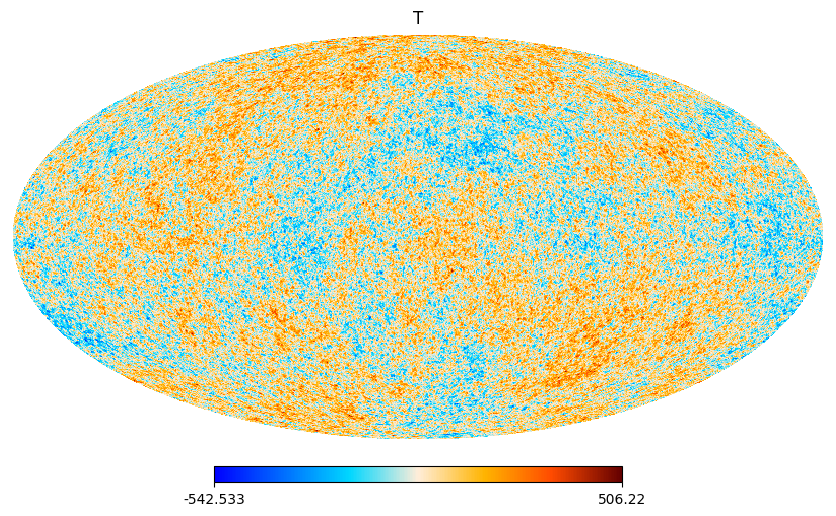

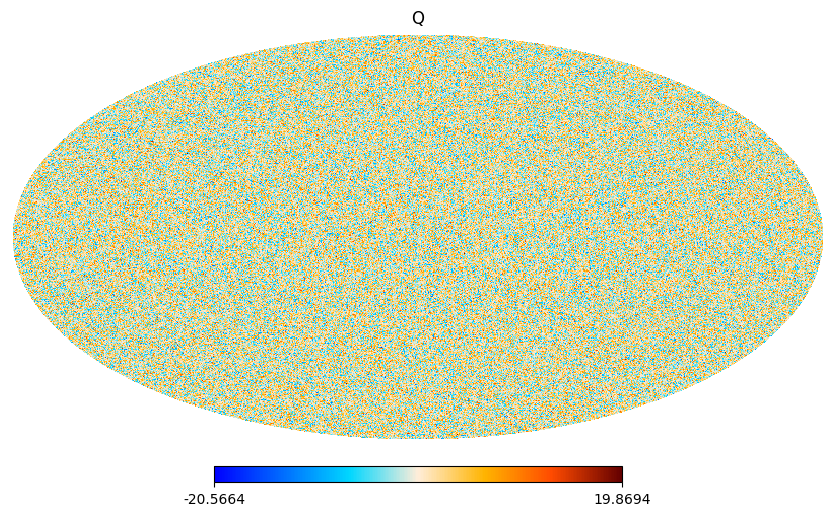

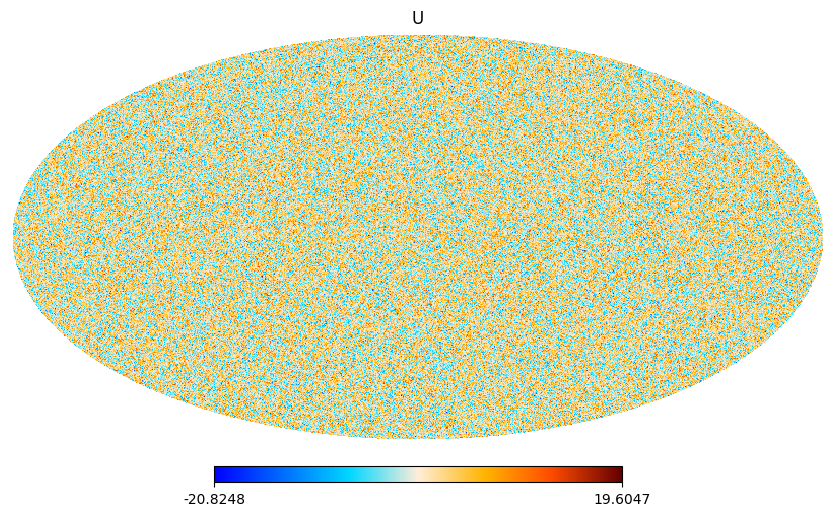

In [13]:
for i, field in enumerate(fields := "TQU"):
    hp.mollview(cmb.data[i], title=field)

### Generate window



We then create an apodisation for the survey mask. We use a C1 apodisation with an apodisation size of 1 degree


In [14]:
from pspy import so_window

window = so_window.create_apodization(binary_healpix, apo_type="C1", apo_radius_degree=1)

We also create a point source mask made of 100 holes each with a 10 arcminutes size



In [15]:
mask = so_map.simulate_source_mask(binary_healpix, n_holes=100, hole_radius_arcmin=10)

and we apodize it



In [16]:
mask = so_window.create_apodization(mask, apo_type="C1", apo_radius_degree=0.3)

The window is given by the product of the survey window and the mask window



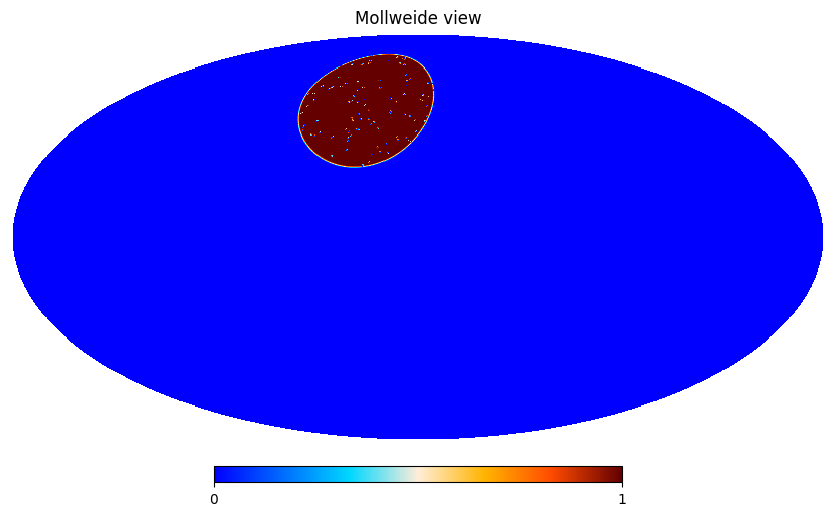

In [18]:
window.data *= mask.data
hp.mollview(window.data, min=0, max=1)

### Compute mode coupling matrix



For spin 0 and 2 the window need to be a tuple made of two objects: the window used for spin 0 and the
one used for spin 2



In [20]:
window = (window, window)

The windows (for `spin0` and `spin2`) are going to couple mode together, we compute a mode coupling
matrix in order to undo this effect given a binning file (format: lmin, lmax, lmean) and a
$\ell$<sub>max</sub> value of 1000



In [21]:
from pspy import pspy_utils

binning_file = os.path.join(output_dir, "binning.dat")
pspy_utils.create_binning_file(bin_size=40, n_bins=100, file_name=binning_file)

from pspy import so_mcm

ℓmax = 1000
mbb_inv, Bbl = so_mcm.mcm_and_bbl_spin0and2(window, binning_file, lmax=ℓmax, type="Dl", niter=0)

### Compute *alms* and bin spectra



In [22]:
from pspy import sph_tools

alms = [sph_tools.get_alms(split, window, niter=0, lmax=lmax) for split in splits]

We need to specify the order of the spectra to be used by `pspy`



In [23]:
spectra = ["TT", "TE", "TB", "ET", "BT", "EE", "EB", "BE", "BB"]

and we finally build a dictionary of cross split spectra



In [24]:
Db_dict = {}
from itertools import combinations_with_replacement as cwr

for (i1, alm1), (i2, alm2) in cwr(enumerate(alms), 2):
    from pspy import so_spectra

    ℓ, ps = so_spectra.get_spectra(alm1, alm2, spectra=spectra)
    lb, Db = so_spectra.bin_spectra(
        ℓ, ps, binning_file, ℓmax, type="Dl", mbb_inv=mbb_inv, spectra=spectra
    )
    Db_dict.update({f"split{i1}xsplit{i2}": Db})

To compare with the input $C_\ell$, we also compute the binned theory spectra



In [26]:
from pspy import pspy_utils

ℓ, ps_theory = pspy_utils.ps_lensed_theory_to_dict(cl_file, "Dl", lmax=ℓmax)
ps_theory_b = so_mcm.apply_Bbl(Bbl, ps_theory, spectra=spectra)

and we finally plot all the results



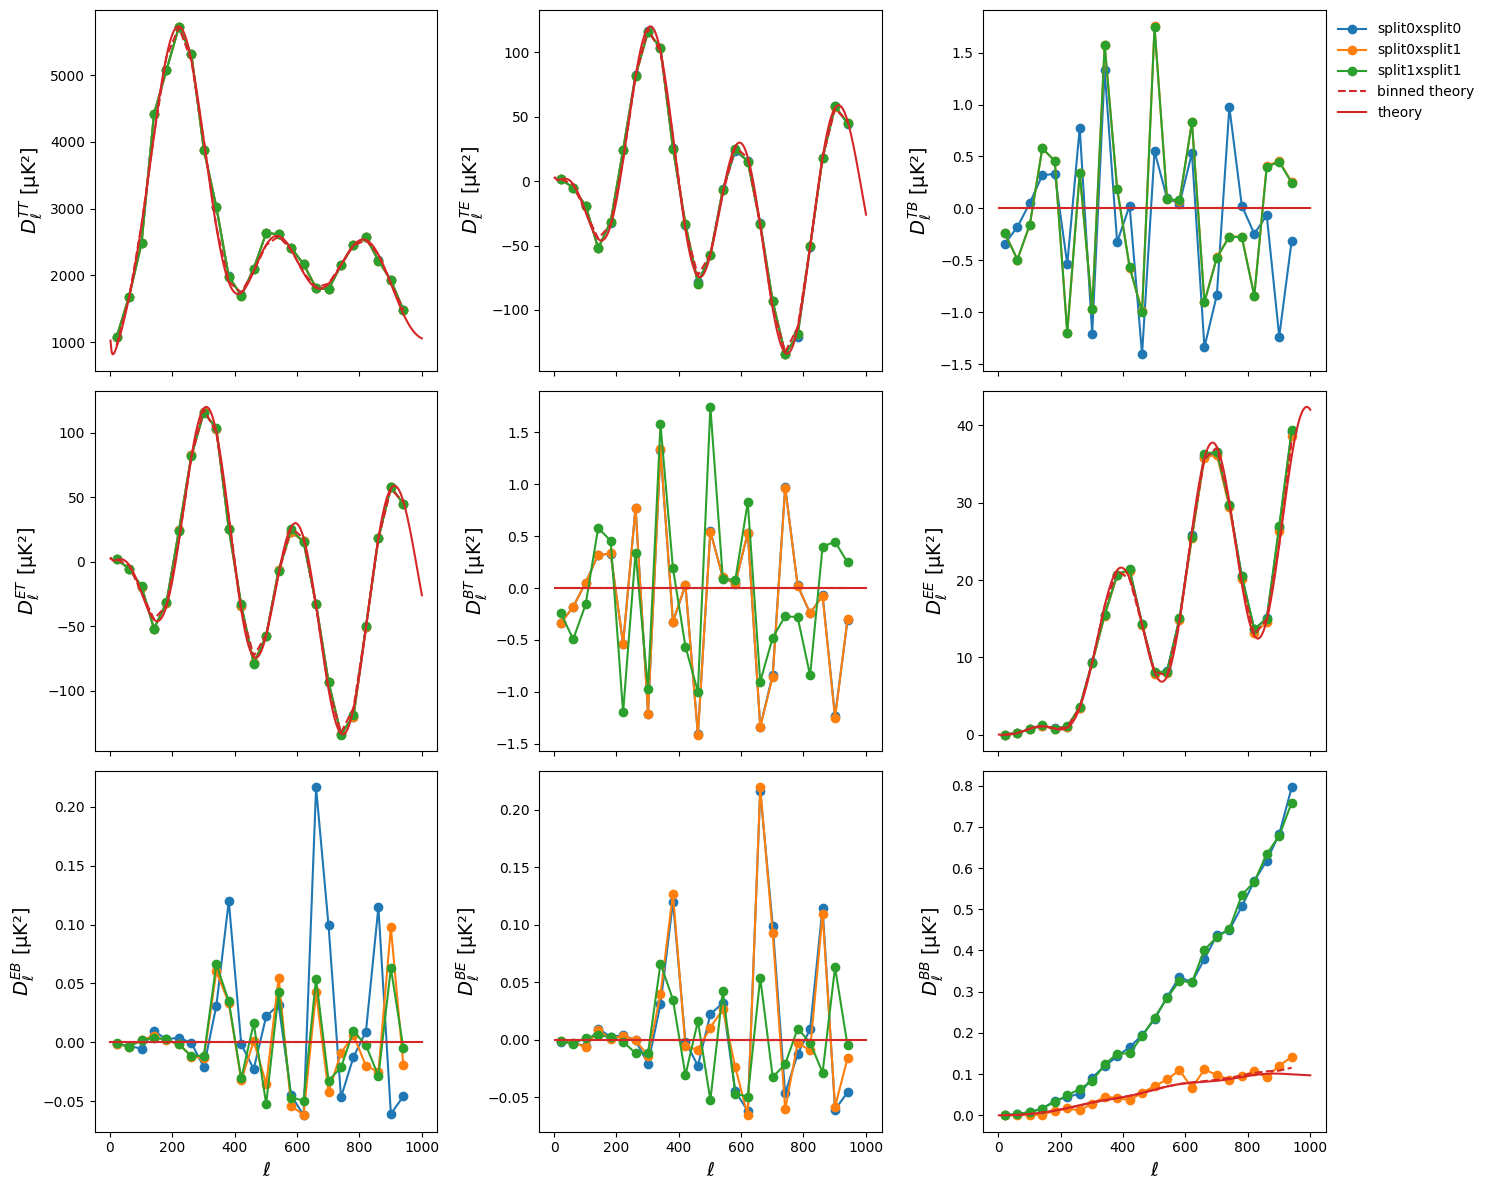

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True)
for ax, spec in zip(axes.flatten(), spectra):
    for k, v in Db_dict.items():
        ax.plot(lb, v[spec], "-o", label=k)
    ax.plot(lb, ps_theory_b[spec], "--", color="tab:red", label="binned theory")
    ax.plot(l, ps_theory[spec], color="tab:red", label="theory")
    ax.set_ylabel(r"$D^{%s}_{\ell}$ [µK²]" % spec, fontsize=14)

for ax in axes[-1]:
    ax.set_xlabel(r"$\ell$", fontsize=14)
axes[0, -1].legend(loc="upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()